# Data Extraction

In [1]:
import numpy as np
import pandas as pd
import re
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,LSTM,Embedding,Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shiv28/next-word")

print("Path to dataset files:", path)

100%|██████████| 249M/249M [00:12<00:00, 20.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shiv28/next-word/versions/3


In [3]:
import os

# List files in the directory
print(os.listdir(path))

['next_word_prediction.txt', 'file4.txt']


In [4]:
file = pd.read_fwf(path + '/next_word_prediction.txt')
file

,Chapter 1
0,"It is a truth universally acknowledged, that a..."
1,"possession of a good fortune, must be in want ..."
2,However little known the feelings or views of ...
3,"on his first entering a neighbourhood, this tr..."
4,fixed in the minds of the surrounding families...
...,...
14683,facility: www.gutenberg.org
14684,This website includes information about Projec...
14685,including how to make donations to the Project...
14686,"Archive Foundation, how to help produce our ne..."


**Extracting corpus**

In [5]:
corpus = ""
for i in range(file.shape[0]):
    corpus += file['Chapter 1'][i]
    corpus += " "
corpus = corpus.lower()
corpus[:500]

'it is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife. however little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered as the rightful property of some one or other of their daughters. “my dear mr. bennet,” said his lady to him one day, “have you heard that netherfield park is let at last?” mr. bennet rep'

In [6]:
len(corpus)

917085

**Removing punctuations(except fullstop) and extra spaces**

In [7]:
corpus = re.sub(r'[,?_;:!@%,’”“]|mrs?(\.)','',corpus)
corpus = re.sub(r'\s+',' ',corpus)
corpus

'it is a truth universally acknowledged that a single man in possession of a good fortune must be in want of a wife. however little known the feelings or views of such a man may be on his first entering a neighbourhood this truth is so well fixed in the minds of the surrounding families that he is considered as the rightful property of some one or other of their daughters. my dear bennet said his lady to him one day have you heard that netherfield park is let at last bennet replied that he had not. but it is returned she for long has just been here and she told me all about it. bennet made no answer. do not you want to know who has taken it cried his wife impatiently. you want to tell me and i have no objection to hearing it. this was invitation enough. why my dear you must know long says that netherfield is taken by a young man of large fortune from the north of england that he came down on monday in a chaise and four to see the place and was so much delighted with it that he agreed w

**Limiting corpus to 50,000 words**

In [12]:
corpus = corpus.split()

In [13]:
len(corpus)

50000

In [14]:
corpus = corpus[:50000]

In [15]:
corpus = " ".join(corpus)

# Integer Tokenization and Sequencing

In [89]:
vocab_size = 1000
tokenizer = Tokenizer(num_words=vocab_size,oov_token='<OOV>')
tokenizer.fit_on_texts([corpus])

In [90]:
list(tokenizer.word_index.items())[:20]

[('<OOV>', 1),
 ('the', 2),
 ('and', 3),
 ('to', 4),
 ('of', 5),
 ('a', 6),
 ('i', 7),
 ('it', 8),
 ('you', 9),
 ('in', 10),
 ('she', 11),
 ('was', 12),
 ('that', 13),
 ('said', 14),
 ('is', 15),
 ('he', 16),
 ('as', 17),
 ('with', 18),
 ('her', 19),
 ('alice', 20)]

In [91]:
len(tokenizer.word_index)+1

5149

# Dataset Preparation

In [92]:
corpus.split('.')[:5]

['it is a truth universally acknowledged that a single man in possession of a good fortune must be in want of a wife',
 ' however little known the feelings or views of such a man may be on his first entering a neighbourhood this truth is so well fixed in the minds of the surrounding families that he is considered as the rightful property of some one or other of their daughters',
 ' my dear bennet said his lady to him one day have you heard that netherfield park is let at last bennet replied that he had not',
 ' but it is returned she for long has just been here and she told me all about it',
 ' bennet made no answer']

**Creating uni-gram,bi-gram,tri-gram... with a single sentence**

In [93]:
sequences = []
for sentence in corpus.split('.'):
  sequence = tokenizer.texts_to_sequences([sentence])[0]
  for i in range(1,len(sequence)):
    sequences.append(sequence[:i+1])
sequences[:5]

[[8, 15], [8, 15, 6], [8, 15, 6, 1], [8, 15, 6, 1, 1], [8, 15, 6, 1, 1, 1]]

In [94]:
lengths = [len(x) for x in sequences]
max(lengths)

299

In [95]:
max_len = max(lengths)
print(max_len)
print(vocab_size)

299
1000


**Padding**

In [96]:
padded_sequences = pad_sequences(sequences,maxlen=max_len,padding='pre')
padded_sequences

array([[ 0,  0,  0, ...,  0,  8, 15],
       [ 0,  0,  0, ...,  8, 15,  6],
       [ 0,  0,  0, ..., 15,  6,  1],
       ...,
       [ 0,  0,  0, ..., 94, 34, 74],
       [ 0,  0,  0, ..., 34, 74,  1],
       [ 0,  0,  0, ..., 74,  1, 10]], dtype=int32)

In [97]:
padded_sequences = np.array(padded_sequences)

In [98]:
X = padded_sequences[:,:-1]
y = padded_sequences[:,-1]
print(X.shape)
print(y.shape)

(47930, 298)
(47930,)


In [99]:
from keras.utils import to_categorical
y = to_categorical(y,num_classes=vocab_size)

In [100]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Model Building

In [133]:
from keras.layers import Dropout,GRU
model = Sequential()
model.add(Input(shape=(298,)))
model.add(Embedding(input_dim=vocab_size,output_dim=200))
model.add(GRU(100,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dense(vocab_size,activation='softmax'))

In [134]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 298, 200)       │       200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 100)            │        90,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1000)           │       101,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 401,700 (1.53 MB)

 Trainable params: 401,700 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

In [135]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

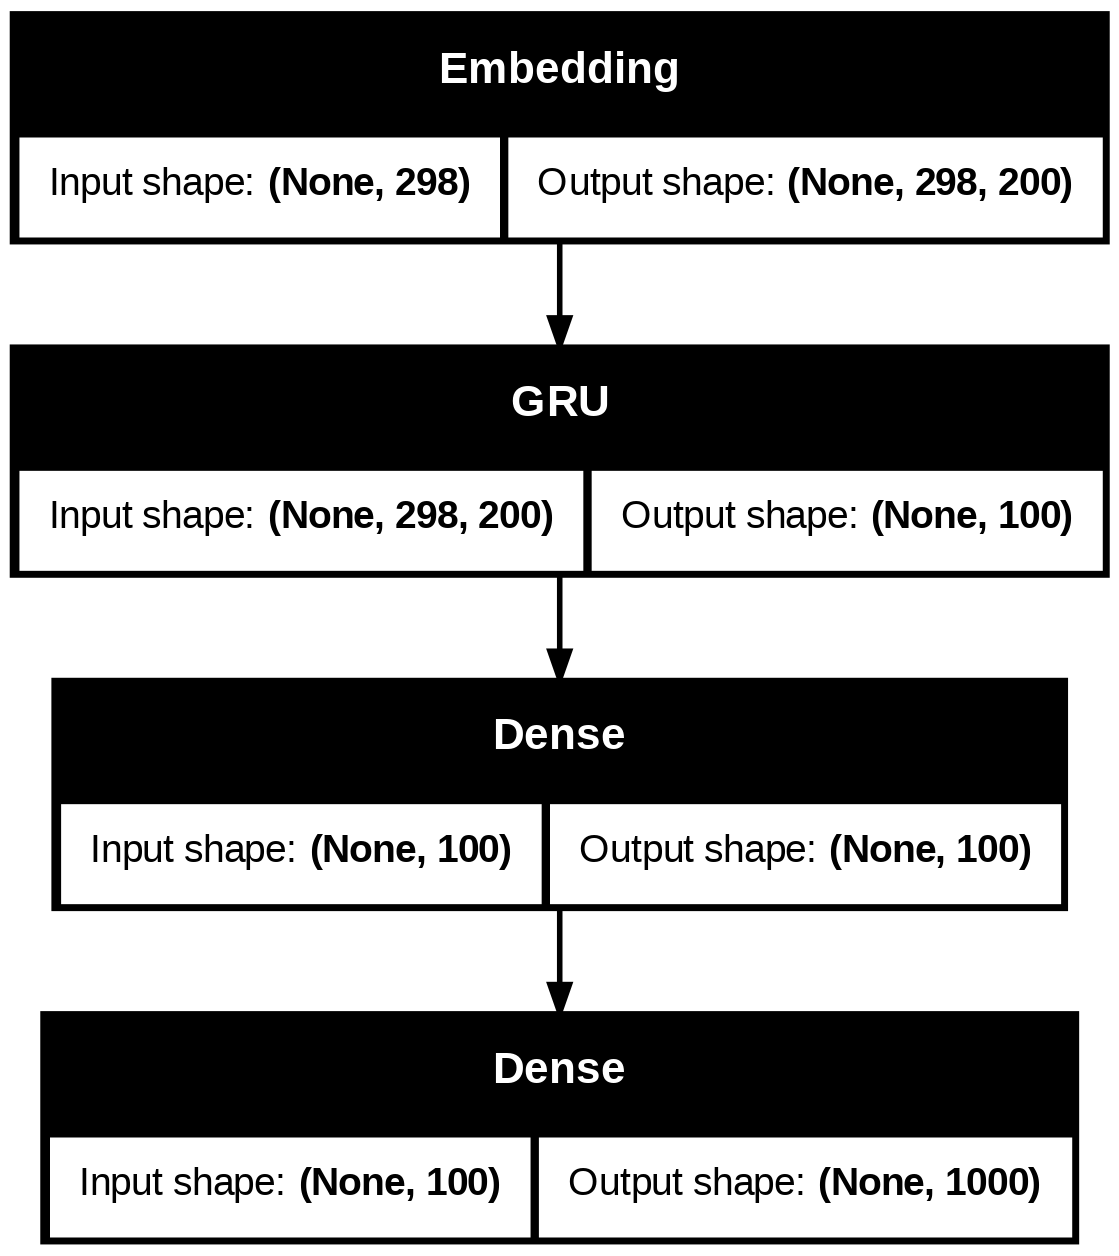

<Figure size 1000x1000 with 0 Axes>

In [120]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
from keras.utils import plot_model
plot_model(model,show_shapes=True)

**Training without earlystopping for better accuracy on seen data**

In [105]:
earlystop = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=0,
    mode='auto',
    start_from_epoch=14,
    restore_best_weights=True
)

In [121]:
model.fit(X_train,y_train,epochs=50,batch_size=64,validation_data=(X_test,y_test))

Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.1436 - loss: 5.5123 - val_accuracy: 0.1738 - val_loss: 4.7836
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.1736 - loss: 4.6537 - val_accuracy: 0.1961 - val_loss: 4.4466
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.1989 - loss: 4.2925 - val_accuracy: 0.2076 - val_loss: 4.3225
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.2118 - loss: 4.0726 - val_accuracy: 0.2136 - val_loss: 4.2752
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.2232 - loss: 3.9163 - val_accuracy: 0.2159 - val_loss: 4.2399
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.2354 - loss: 3.7432 - val_accuracy: 0.2212 - val_loss: 4.2423
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.2461 - loss: 3.6264 - val_accuracy: 0.2209 - val_loss: 4.2775
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.2553 - loss: 3.4803 - 

**Training on entire dataset for better training accuracy**

In [136]:
model.fit(X,y,epochs=60,batch_size=64)

Epoch 1/60
749/749 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.1434 - loss: 5.4276
Epoch 2/60
749/749 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.1829 - loss: 4.5197
Epoch 3/60
749/749 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.2025 - loss: 4.2150
Epoch 4/60
749/749 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.2130 - loss: 4.0387
Epoch 5/60
749/749 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.2333 - loss: 3.8497
Epoch 6/60
749/749 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.2383 - loss: 3.7259
Epoch 7/60
749/749 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.2518 - loss: 3.5744
Epoch 8/60
749/749 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.2600 - loss: 3.4366
Epoch 9/60
749/749 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.2659 - loss: 3.3368
Epoch 10/60
749/749 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.2823 - loss: 3.2039
Epoch 11/60
749/749 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.2923 - loss: 3.0968
Epoch 12/60
749/749 ━━━━━━━━━━

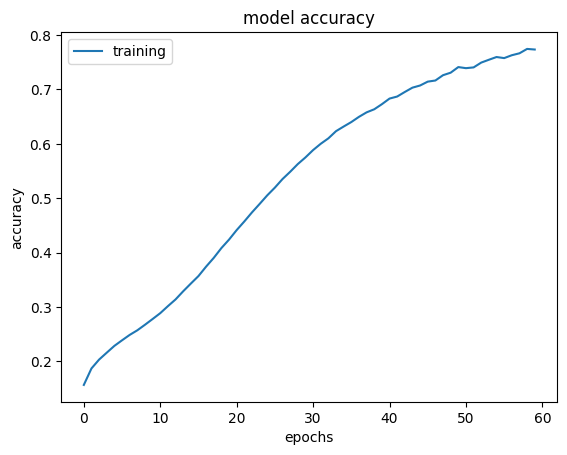

In [139]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['accuracy'],label='training')
plt.legend()
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

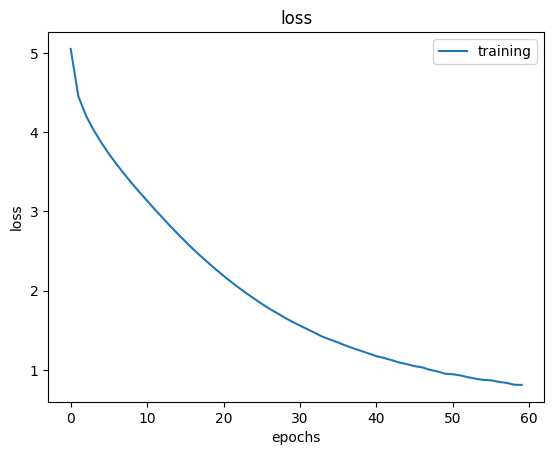

In [141]:
plt.plot(model.history.history['loss'],label='training')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('loss')
plt.show()

In [142]:
corpus.split('.')[:10]

['it is a truth universally acknowledged that a single man in possession of a good fortune must be in want of a wife',
 ' however little known the feelings or views of such a man may be on his first entering a neighbourhood this truth is so well fixed in the minds of the surrounding families that he is considered as the rightful property of some one or other of their daughters',
 ' my dear bennet said his lady to him one day have you heard that netherfield park is let at last bennet replied that he had not',
 ' but it is returned she for long has just been here and she told me all about it',
 ' bennet made no answer',
 ' do not you want to know who has taken it cried his wife impatiently',
 ' you want to tell me and i have no objection to hearing it',
 ' this was invitation enough',
 ' why my dear you must know long says that netherfield is taken by a young man of large fortune from the north of england that he came down on monday in a chaise and four to see the place and was so much d

In [143]:
pred_word = ""
text = input("Enter text: ")
text = text.lower()
for i in range(5):
  sequence = tokenizer.texts_to_sequences([text])[0]
  sequence = pad_sequences([sequence],maxlen=max_len,padding='pre')
  prediction = model.predict(sequence)
  prediction = np.argmax(prediction,axis=1)
  for word,index in tokenizer.word_index.items():
    if index == prediction:
      text += " "
      text += word
      print(text)
print(pred_word)

Enter text: my dear bennet
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
my dear bennet said
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
my dear bennet said his
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
my dear bennet said his lady
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
my dear bennet said his lady to
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
my dear bennet said his lady to his



In [147]:
pred_word = ""
text = input("Enter text: ")
text = text.lower()
for i in range(5):
  sequence = tokenizer.texts_to_sequences([text])[0]
  sequence = pad_sequences([sequence],maxlen=max_len,padding='pre')
  prediction = model.predict(sequence)
  prediction = np.argmax(prediction,axis=1)
  for word,index in tokenizer.word_index.items():
    if index == prediction:
      text += " "
      text += word
      print(text)
print(pred_word)

Enter text: little known the feelings
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
little known the feelings or
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
little known the feelings or <OOV>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
little known the feelings or <OOV> of
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
little known the feelings or <OOV> of this
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
little known the feelings or <OOV> of this agreement

